### Define some args.

In [1]:
import os

DATA_PATH = 'data'

GD_ZIP_IMG = '/content/gdrive/MyDrive/DL4CV-2022/project-II/data/images.zip'
GD_ZIP_GAN = '/content/gdrive/MyDrive/DL4CV-2022/project-II/data/gans.zip'

IMAGE_PATH = os.path.join(DATA_PATH, 'images')
IMG_ZIP_FILE = os.path.join(DATA_PATH, 'images.zip')
GAN_ZIP_FILE = os.path.join(DATA_PATH, 'gans.zip') # mohammed's GANs

### Download code from Github.

In [2]:
import os

if os.path.isfile("../main.zip"):
  print ('Have already downloaded the project file, continuing...')
  print()
else:
  print ('Downloading file...')
  ! wget https://github.com/geraldmc/torch-draft-final_project/archive/refs/heads/main.zip
  ! unzip -qq main.zip
  %cd torch-draft-final_project-main

--2022-04-19 00:25:35--  https://github.com/geraldmc/torch-draft-final_project/archive/refs/heads/main.zip
Resolving github.com (github.com)... 52.69.186.44
Connecting to github.com (github.com)|52.69.186.44|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://codeload.github.com/geraldmc/torch-draft-final_project/zip/refs/heads/main [following]
--2022-04-19 00:25:35--  https://codeload.github.com/geraldmc/torch-draft-final_project/zip/refs/heads/main
Resolving codeload.github.com (codeload.github.com)... 52.68.31.213
Connecting to codeload.github.com (codeload.github.com)|52.68.31.213|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/zip]
Saving to: ‘main.zip’

main.zip                [  <=>               ] 965.21K  4.16MB/s    in 0.2s    

2022-04-19 00:25:36 (4.16 MB/s) - ‘main.zip’ saved [988372]

/content/torch-draft-final_project-main


In [3]:
# Import local libs in a try block
try:
  import conf.params as params
except ImportError:
  pass

### Access Google Drive.

In [4]:
from google.colab import drive

drive.mount('/content/gdrive')
print()
print("Downloading DeepWeeds images to " + IMG_ZIP_FILE)
!cp '{GD_ZIP_IMG}' '{IMG_ZIP_FILE}'
print()
!ls -lart {IMG_ZIP_FILE}

print()
print("Downloading GAN images to " + GAN_ZIP_FILE)
!cp '{GD_ZIP_GAN}' '{GAN_ZIP_FILE}'
print()
!ls -lart {GAN_ZIP_FILE}

Mounted at /content/gdrive


-rw------- 1 root root 491516047 Apr 19 00:26 data/images.zip


-rw------- 1 root root 89648790 Apr 19 00:26 data/gans.zip


### Unzip real and GAN images.

In [5]:
from zipfile import ZipFile

print("Unzipping DeepWeeds images into " + IMAGE_PATH)

with ZipFile(IMG_ZIP_FILE, "r") as zip_ref:
    zip_ref.extractall(IMAGE_PATH)

img_list=os.listdir(IMAGE_PATH)
print(len(img_list))

print()
print("Unzipping GAN image dirs into " + DATA_PATH)

with ZipFile(GAN_ZIP_FILE, "r") as zip_ref:
    zip_ref.extractall(DATA_PATH)

gan_dir_list=os.listdir(DATA_PATH+'/gans/train/0')
print(len(gan_dir_list))

Unzipping DeepWeeds images into data/images
17510

Unzipping GAN image dirs into data
250


In [6]:
gan_dir_list=os.listdir(DATA_PATH+'/gans/train/0')
gan_dir_list[0:5]

['100002.png', '8000022.png', '700009.png', '5000024.png', '300006.png']

### Preprocess a single image to be run through ResNet50 model.

In [7]:
# Sample load and execute
from PIL import Image
import torch
from torchvision import transforms

preprocess = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

def single_image_loader(img):
    image = Image.open(img)
    input_tensor = preprocess(image)
    input_batch = input_tensor.unsqueeze(0) # creates a mini-batch.
    if torch.cuda.is_available():
        input_batch = input_batch.to('cuda')
    return image, input_batch

### Instantiate pre-trained model and alter fully-connected layer.

In [8]:
import torch
resnet50_gan = torch.hub.load('pytorch/vision:v0.10.0', 'resnet50', pretrained=True)

Downloading: "https://github.com/pytorch/vision/archive/v0.10.0.zip" to /root/.cache/torch/hub/v0.10.0.zip
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

In [9]:
import torch.nn as nn
# What the number of input parameters going into the last fc layer?
num_final_in = resnet50_gan.fc.in_features

# The final layer of the model is [model].fc. We can overwrite this 
# to have the output = number of classes that we want. We want 9 classes.
NUM_CLASSES = 9
resnet50_gan.fc = nn.Linear(num_final_in, NUM_CLASSES)

### Process GAN image to model and get a probability result. 

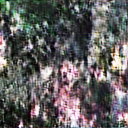

In [10]:
# move the input and model to GPU
if torch.cuda.is_available():
    resnet50_gan.to('cuda')

filename = DATA_PATH +'/gans/train/0' + '/' + gan_dir_list[1]
#!ls {filename}
image, input_batch = single_image_loader(filename)
display(image)

with torch.no_grad():
    output = resnet50_gan(input_batch)
# Tensor of shape 1000, with confidence scores over Imagenet's 1000 classes
# print(output[0]) # output has unnormalized scores
# To get probabilities, you can run a softmax on it.
probabilities = torch.nn.functional.softmax(output[0], dim=0)

In [11]:
probabilities # probability of this image belonging to 0-9th class.

tensor([0.1113, 0.1006, 0.1517, 0.1194, 0.0922, 0.1285, 0.0826, 0.1120, 0.1015],
       device='cuda:0')